In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u 
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import regions
from regions import Regions
from astropy.nddata import Cutout2D
import reproject
from reproject import reproject_interp
from astropy.visualization import simple_norm
from spectral_cube import SpectralCube
import scipy.ndimage as nd

In [2]:
pwd

'/blue/adamginsburg/savannahgramze/proposals/sagittariusE'

In [3]:
cd /blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [4]:
import cutout_manager as cm

In [5]:
cd /blue/adamginsburg/savannahgramze/proposals/sagittariusE

/blue/adamginsburg/savannahgramze/proposals/sagittariusE


In [7]:
coord_fovb.ra

NameError: name 'coord_fovb' is not defined

In [11]:
coord_fova = SkyCoord('17:42:30.6943', '-30:10:46.49', unit=(u.hourangle, u.deg), frame='icrs')
coord_fovb = SkyCoord('17 42 48.5880', '-30 05 56.64', unit=(u.hourangle, u.deg), frame='icrs')
coord_fov_niriss = SkyCoord(coord_fovb.ra-4.*u.arcmin, coord_fovb.dec+5*u.arcmin, frame='icrs')

l = 6*u.arcmin
w = 2*u.arcmin

reg_fova = regions.RectangleSkyRegion(center=coord_fova, width=w, height=l)
reg_fovb = regions.RectangleSkyRegion(center=coord_fovb, width=w, height=l)
reg_fov_niriss = regions.RectangleSkyRegion(center=coord_fov_niriss, width=4.26*u.arcmin/2, height=2.9*u.arcmin)

In [24]:
coord = SkyCoord(358.7436209429, 0, unit=(u.deg, u.deg), frame='galactic')
l = 20*u.arcmin
w = 35*u.arcmin

rgb_dat, rgb_wcs = cm.get_cutout_glimpse_rgb(coord, l, w)

cube_fn = '/orange/adamginsburg/galactic_plane_surveys/sedigism/sedigism/SgrE_13CO_smooth.fits'
reg = regions.RectangleSkyRegion(center=coord, width=w, height=l)

cube = SpectralCube.read(cube_fn).with_spectral_unit(u.km/u.s, velocity_convention='radio').subcube_from_regions([reg])
subcube = cube.spectral_slab(-220*u.km/u.s, -170*u.km/u.s)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


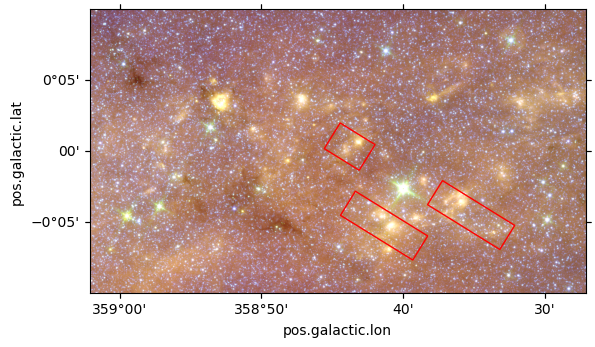

In [ ]:
ax = plt.subplot(projection=rgb_wcs)
ax.imshow(rgb_dat, origin='lower')#, norm=simple_norm(cutout_rgb.data, stretch='sqrt', max_percent=99.9))
reg_fova.to_pixel(rgb_wcs).plot(ax=ax, edgecolor='red')
reg_fovb.to_pixel(rgb_wcs).plot(ax=ax, edgecolor='red')
reg_fov_niriss.to_pixel(rgb_wcs).plot(ax=ax, edgecolor='red')

In [25]:
noise = cube.spectral_slab(-300*u.km/u.s, -250*u.km/u.s).std(axis=0)
peak = subcube.max(axis=0)
spatial_mask = peak > 3*noise

In [26]:
subcube_masked = subcube.with_mask(spatial_mask)

In [27]:
mom0_masked = subcube_masked.moment0()
mom0 = subcube.moment0()

In [28]:
def percentile_list(data, percents=[91]):
    return [np.nanpercentile(data, p) for p in percents]

In [29]:
resampled = nd.gaussian_filter(mom0.value, 1)

In [30]:
spatial_mask

array([[False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False,  True],
       ...,
       [False,  True, False, ..., False, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False]])

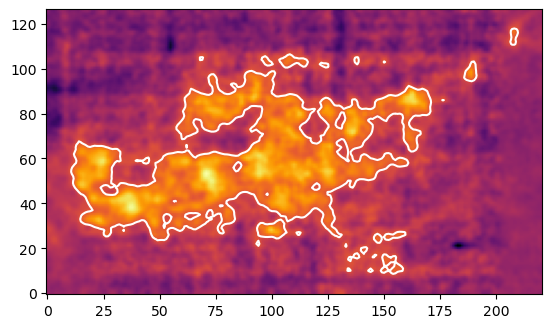

In [31]:
plt.imshow(resampled, origin='lower', cmap='inferno')#, vmin=percentile_list(resampled, [5])[0], vmax=percentile_list(resampled, [95])[0])
plt.contour(resampled, levels=[percentile_list(resampled, [80])[0]], colors='white')

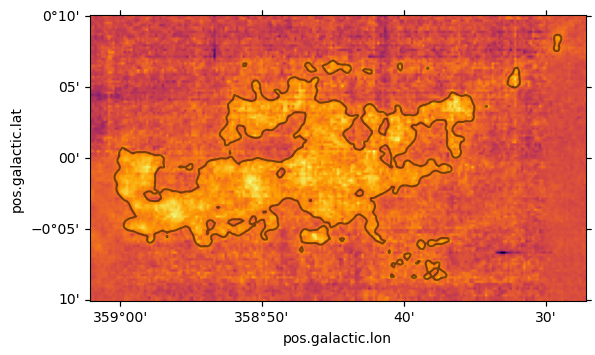

In [32]:
ax = plt.subplot(projection=mom0.wcs)
#ax.imshow(resampled, origin='lower', cmap='inferno')
ax.imshow(mom0.value, origin='lower', cmap='inferno')
ax.contour(resampled, levels=percentile_list(resampled, [80]), colors='k', alpha=0.5)

In [33]:
mask_res = resampled > np.nanpercentile(resampled, 80)
masked_cube = subcube.with_mask(mask_res)
mom1 = masked_cube.moment1()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


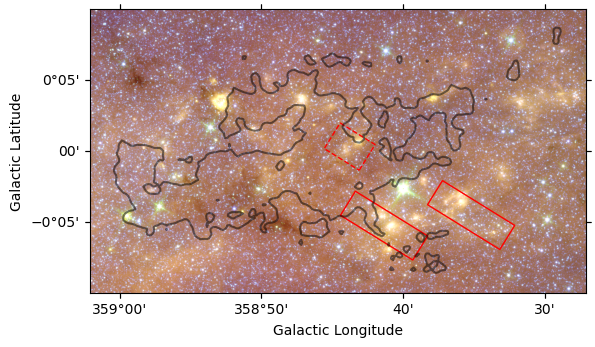

In [36]:
ax = plt.subplot(projection=rgb_wcs)
ax.imshow(rgb_dat, origin='lower')#, norm=simple_norm(cutout_rgb.data, stretch='sqrt', max_percent=99.9))
ax.contour(resampled, levels=percentile_list(resampled, [80]), colors='k', transform=ax.get_transform(mom0.wcs), alpha=0.5)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

reg_fova.to_pixel(rgb_wcs).plot(ax=ax, edgecolor='red')
reg_fovb.to_pixel(rgb_wcs).plot(ax=ax, edgecolor='red')
reg_fov_niriss.to_pixel(rgb_wcs).plot(ax=ax, edgecolor='red', linestyle='dashed')

plt.savefig('sgrE_mom0_contour_fov.png', dpi=300, bbox_inches='tight')
plt.savefig('sgrE_mom0_contour_fov.pdf', bbox_inches='tight')

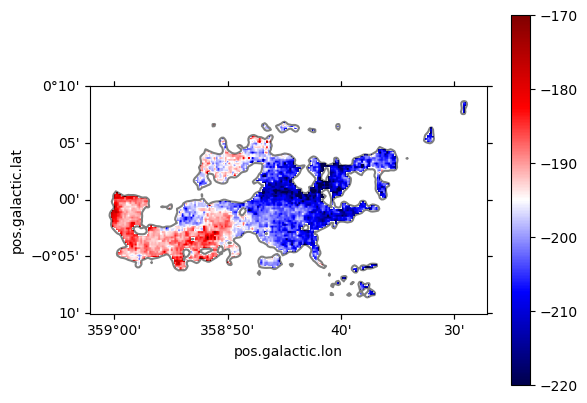

In [24]:
ax = plt.subplot(projection=mom1.wcs)
im = ax.imshow(mom1.value, origin='lower', cmap='seismic', vmin=-220, vmax=-170)
ax.contour(resampled, levels=percentile_list(resampled, [80]), colors='k', alpha=0.5)
plt.colorbar(im)

In [15]:
coord_wide = SkyCoord(359.5820923955, 0, unit=(u.deg, u.deg), frame='galactic')
l_wide = 40*u.arcmin
w_wide = 2.25*u.deg

reg_wide = regions.RectangleSkyRegion(center=coord_wide, width=w_wide, height=l_wide)

rgb_dat_wide, rgb_wcs_wide = cm.get_cutout_glimpse_rgb(coord_wide, l_wide, w_wide)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


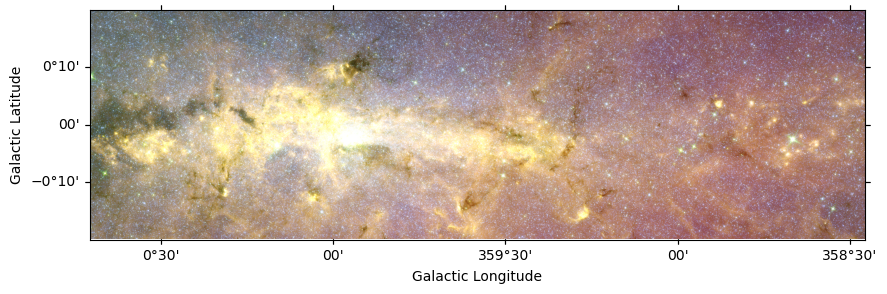

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=rgb_wcs_wide)
ax.imshow(rgb_dat_wide, origin='lower')
#ax.contour(resampled, levels=percentile_list(resampled, [80]), colors='k', transform=ax.get_transform(mom0.wcs), alpha=0.5)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


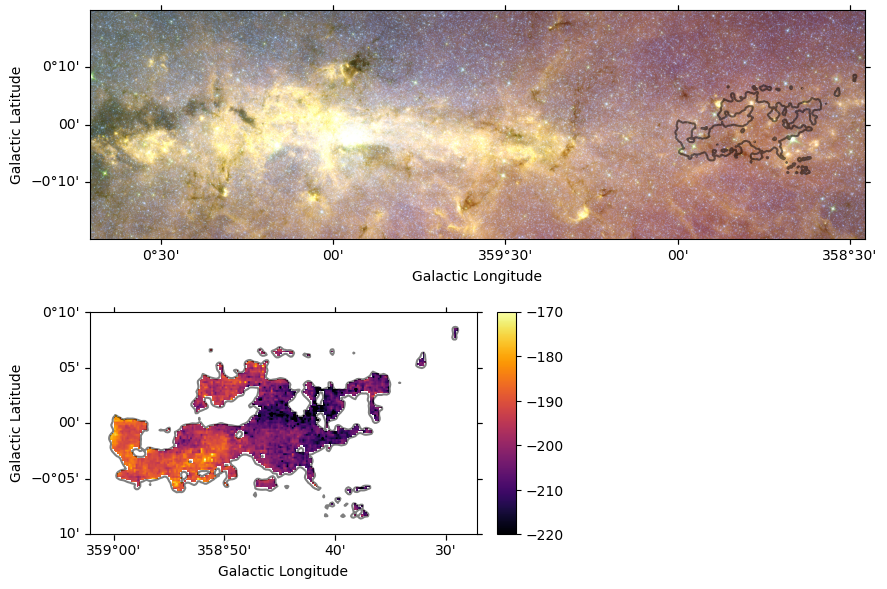

In [61]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=rgb_wcs_wide)
ax.imshow(rgb_dat_wide, origin='lower')
ax.contour(resampled, levels=percentile_list(resampled, [80]), colors='k', transform=ax.get_transform(mom0.wcs), alpha=0.5)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

inset_ax = ax.inset_axes([0, -1.3, 0.5, 1], projection=mom1.wcs)
im = inset_ax.imshow(mom1.value, origin='lower', cmap='inferno', vmin=-220, vmax=-170)
inset_ax.contour(resampled, levels=percentile_list(resampled, [80]), colors='k', alpha=0.5)
inset_ax.set_xlabel('Galactic Longitude')
inset_ax.set_ylabel('Galactic Latitude')
cbar_ax = inset_ax.inset_axes([1.05, 0, 0.05, 1])
fig.colorbar(im, cax=cbar_ax)
